In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import sys
from PIL import Image
import pandas as pd
import torch
from typing import List
sys.path.append('../../utils')
sys.path.append('../yolor')
from pathlib import Path
sys.path.append('../../')
from dataset import get_paths, PathLike, is_image
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from shapely.geometry import Polygon as sPolygon

In [2]:
predict_root = '../../yolov5/runs/predict-seg/large_predict/labels/'
predict_root = '../../yolov5/runs/predict-seg/large_predict/labels/'
small_predict_root = '../../yolov5/runs/predict-seg/small_pred/labels/'


large_labels = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths(predict_root)))
train_labels = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../../../dataset/segmentation/seg/')))
small_labels = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths(small_predict_root)))
print(len(large_labels), len(train_labels), len(small_labels))

# f = lambda x: True if x.split('/')[-1] in [y.split("/")[-1] for y in large_labels] else False
# for t in train_labels:
#     if f(t):
#         pass
#     else:
#         train_labels.remove(t)
        
# print(len(large_labels), len(train_labels))

def read_segmentation_labels(p: PathLike):
    with open(p, 'r') as f:
        lines = f.readlines()
        return [np.fromstring(line, sep=' ') for line in lines]

394 394 248


In [3]:
def plot_masks(segments: List[np.ndarray], fig = None, color = [0,0,1], alpha = 1):
    if fig:
        fig = fig
        ax = fig.gca()
    else:
        fig = plt.figure(figsize = (10,10))
        ax = fig.gca()
        
    for i,label in enumerate(segments):
        polygon = Polygon([(x,y) for x,y in zip(label[1::2],label[2::2])], alpha)
        polygon.set_color(color)
        polygon.set_alpha(alpha)
        ax.add_patch(polygon)
        plt.ylim(0,1024)
        plt.xlim(0,1024)
    return fig

In [38]:
def create_polygon(segment):
    return sPolygon([(x,y) for x,y in zip(segment[0::2],segment[1::2])])

def merge_serments(train_segments, other_segments, squre_thresh = 1000):
    ans = train_segments.copy()
    for segment in other_segments:
        p1 = create_polygon(segment[1:])
        p1 = p1.buffer(0)
        interection_segments = []
        for train_segment in train_segments:
            p2 = create_polygon(train_segment[1:])
            p2 = p2.buffer(0)
            area_interection = p1.intersection(p2).area
            if area_interection > 0:
                interection_segments.append(segment)
        if len(interection_segments) == 0:
            if p1.area > squre_thresh: #tresh добавит
                ans.append(segment)
        elif len(interection_segments) == 1:
            p2 = create_polygon(interection_segments[0][1:])
            p2 = p2.buffer(0)
            iou = p1.intersection(p2).area / p1.union(p2).area
            if iou>0.85 and iou<0.99:
                ans.append(segment)
            if iou<0.2:
                ans.append(segment)
        else:
            s = 0
            for inter_seg in interection_segments:
                p2 = create_polygon(inter_seg[1:])
                p2 = p2.buffer(0)
                s+=p1.intersection(p2).area/p1.union(p2).area
            if s/len(interection_segments) < 0.15:
                ans.append(segment)
    return ans

In [39]:
ind = 90
pred  = read_segmentation_labels(large_labels[ind])
train = [label*1024 for label in read_segmentation_labels(train_labels[ind])]
small = read_segmentation_labels(small_labels[ind])
name = small_labels[ind].split('/')[-1]
create_polygon(train[0]).area

433.2820889600059

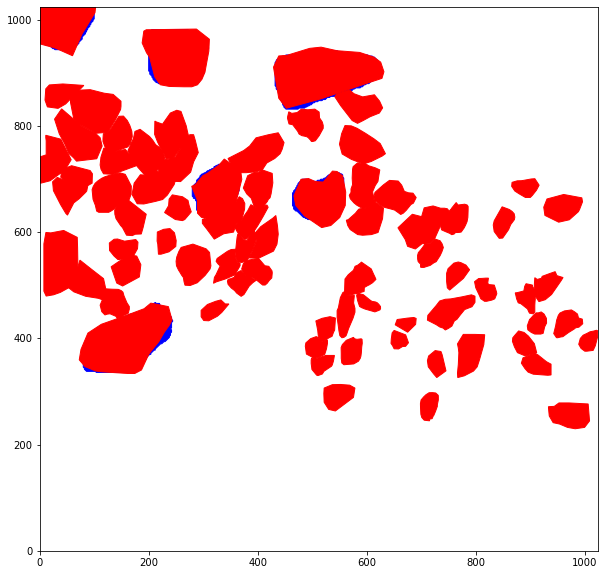

In [40]:
f = plot_masks(pred)
f = plot_masks(train,f,color=[1,0,0],)

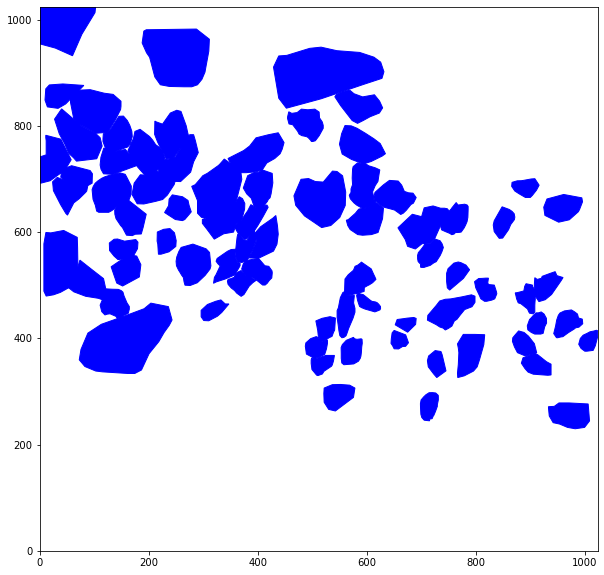

In [41]:
merge = merge_serments(train, pred)
f = plot_masks(merge)

1


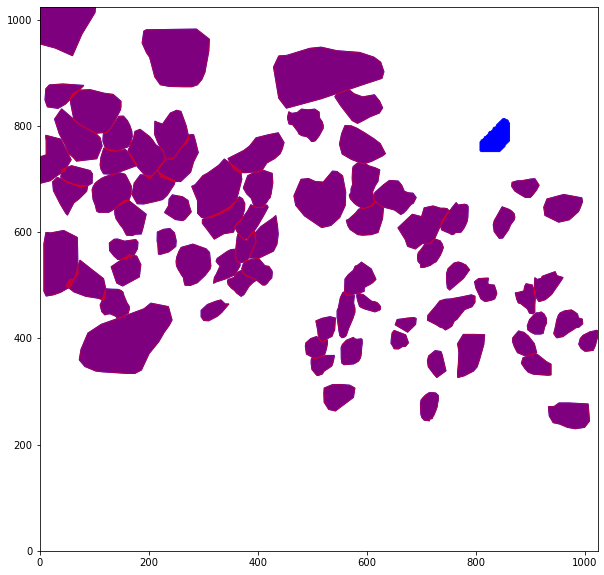

In [42]:
trains_names = [x.split('/')[-1] for x in get_paths('/home/kirilman/Project/dataset/segmentation/labels/small/train')]
names_small = {x.split('/')[-1]:x for x in small_labels}

if name in names_small:
    other_labels = read_segmentation_labels(names_small[name])
print(len(other_labels))
f = plot_masks(merge_serments(merge, other_labels))
f = plot_masks(train,f,[1,0,0], alpha= 0.5)

In [43]:
def to_string(arr):
    s = ""
    for i,x in enumerate(arr):
        if i == 0:
            s+=str(int(x))+" "
        else:
            s+=str(np.round(x,4))+" "
    s = s[:-1] + "\n"
    return s

def write_labels(p: Path, labels: List[np.ndarray], scale = 1024):
    with open(p,'w') as f:
        for l in labels:
            f.write(to_string(l/scale))

In [44]:
names_small = {x.split('/')[-1]:x for x in small_labels}

for ind in range(len(large_labels)):
    pred  = read_segmentation_labels(large_labels[ind])
    train = [label for label in read_segmentation_labels(train_labels[ind])]
    for l in train:
        l[1:] = l[1:]*1024
        
    merge_labels = merge_serments(train, pred)
    #small labels
    name = large_labels[ind]
    if name in names_small:
        other_labels = read_segmentation_labels(names_small[name])
        merge_labels = merge_serments(merge_labels, other_labels)
    save_path = '../../../dataset/segmentation/merge_labels/' + Path(large_labels[ind]).name
    write_labels(save_path, merge_labels, 1024)
    if ind%50==0:
        print(ind, flush=True)

0
50
100
150
200
250
300
350


In [54]:
from dataset.path_utils import copy
import shutil
from dataset.processor import SegmentSquareFilter
from dataset.path_utils import get_paths_from_dirs
files = get_paths_from_dirs(['../../../dataset/segmentation/merge_labels/'], ['txt'])

In [55]:
for f in files:
    seg = SegmentSquareFilter(f, '../../../dataset/segmentation/merge_labels/', 0.001, True)
    seg.process()

In [56]:
trains_names = [x.split('/')[-1] for x in get_paths('/home/kirilman/Project/dataset/segmentation/labels/small/train')]
source_path = '/home/kirilman/Project/dataset/segmentation/labels/merge_labels/train/'
for t in get_paths('/home/kirilman/Project/dataset/segmentation/merge_labels/'):
    if t.split('/')[-1] in trains_names:
        shutil.copy(t, source_path + Path(t).name)

In [57]:
trains_names = [x.split('/')[-1] for x in get_paths('/home/kirilman/Project/dataset/segmentation/labels/small/test/')]
source_path = '/home/kirilman/Project/dataset/segmentation/labels/merge_labels/test/'
for t in get_paths('/home/kirilman/Project/dataset/segmentation/merge_labels/'):
    if t.split('/')[-1] in trains_names:
        shutil.copy(t, source_path + Path(t).name)

trains_names = [x.split('/')[-1] for x in get_paths('/home/kirilman/Project/dataset/segmentation/labels/small/val/')]
source_path = '/home/kirilman/Project/dataset/segmentation/labels/merge_labels/val/'
for t in get_paths('/home/kirilman/Project/dataset/segmentation/merge_labels/'):
    if t.split('/')[-1] in trains_names:
        shutil.copy(t, source_path + Path(t).name)

In [79]:
def merge_serments(train_segments, other_segments, squre_thresh = 1000):
    ans = train_segments.copy()
    for segment in other_segments:
        p1 = create_polygon(segment[1:])
        p1 = p1.buffer(0)
        interection_segments = []
        for train_segment in train_segments:
            p2 = create_polygon(train_segment[1:])
            p2 = p2.buffer(0)
            area_interection = p1.intersection(p2).area
            if area_interection > 0:
                interection_segments.append(segment)
        if len(interection_segments) == 0:
            if p1.area > squre_thresh: #tresh добавит
                ans.append(segment)
        elif len(interection_segments) == 1:
            p2 = create_polygon(interection_segments[0][1:])
            p2 = p2.buffer(0)
            iou = p1.intersection(p2).area / p1.union(p2).area
            if iou>0.85 and iou<0.99:
                ans.append(segment)
            if iou<0.2:
                ans.append(segment)
        else:
            s = 0
            for inter_seg in interection_segments:
                p2 = create_polygon(inter_seg[1:])
                p2 = p2.buffer(0)
                s+=p1.intersection(p2).area/p1.union(p2).area
            if s/len(interection_segments) < 0.15:
                ans.append(segment)
    return ans

for f in files:
    labels  = read_segmentation_labels(f)
    for label in labels:
        for other_label in labels:
            if not (label[5] == other_label[5]):
                p1 = create_polygon(label)
                p2 = create_polygon(other_label)
                p1 = p1.buffer(0)
                p2 = p2.buffer(0)
                iou = p1.intersection(p2).area / p1.union(p2).area
                if iou > 0.6:
                    print(f, p1)

../../../dataset/segmentation/merge_labels/GeneralImage_11-11-2021-12-24-03.txt POLYGON ((0 0.2268, 0.6737840074654213 0.239409691071322, 0.671 0.2375, 0.6658 0.2256, 0.6568 0.2202, 0.6555162201433244 0.210785614384379, 0 0.2268))
../../../dataset/segmentation/merge_labels/GeneralImage_11-11-2021-12-24-03.txt POLYGON ((0 0.2243, 0.5918478266610732 0.2432632332543, 0.6078 0.231, 0.6368 0.2188, 0.6378539615991403 0.2174527621297945, 0 0.2243))
../../../dataset/segmentation/merge_labels/ManualGeneralImage_14_01_51.txt POLYGON ((0 0.4235, 0.8893542355634698 0.4562118799287713, 0.8896 0.454, 0.893 0.4391, 0.8997 0.4271, 0.9097 0.4221, 0 0.4235))
../../../dataset/segmentation/merge_labels/ManualGeneralImage_14_01_51.txt POLYGON ((0 0.423, 0.8583287291834928 0.4603440762555126, 0.8713 0.4425, 0.882 0.4223, 0 0.423))
../../../dataset/segmentation/merge_labels/637412007102987769.txt POLYGON ((0 0.2415, 0.1313 0.2488, 0.1256 0.2608, 0.1238 0.2809, 0.1238 0.2871, 0.1256 0.2936, 0.1356 0.2963, 0.1

In [90]:
p = Path('../../../dataset/segmentation/seg/1_11_32_12_16-03-2020_1.txt')
with open(p,'r') as f:
    lb = [x.split() for x in f.read().strip().splitlines() if len(x)]
    classes = np.array([x[0] for x in lb], dtype=np.float32)
    segments = [np.array(x[1:], dtype=np.float32).reshape(-1, 2) for x in lb]
    lb = np.concatenate((classes.reshape(-1, 1), segments), 1)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [88]:
segments[0]

array([[0.7424, 0.0566],
       [0.7316, 0.0377],
       [0.7099, 0.024 ],
       [0.6829, 0.0206],
       [0.6504, 0.012 ],
       [0.6274, 0.036 ],
       [0.6084, 0.0754],
       [0.5908, 0.1097],
       [0.5678, 0.1508],
       [0.5488, 0.1782],
       [0.5502, 0.1988],
       [0.5732, 0.2039],
       [0.6043, 0.2039],
       [0.6246, 0.2176],
       [0.6693, 0.2416],
       [0.7018, 0.2588],
       [0.7221, 0.2708],
       [0.7438, 0.2468],
       [0.783 , 0.2279],
       [0.7857, 0.1988],
       [0.7871, 0.1508],
       [0.7736, 0.1097],
       [0.7519, 0.0806]], dtype=float32)